# Machine Learning Example

Python macro for classifying events (in 2D) using Machine Learning (based on SciKitLearn). The 2D case is chosen, so that the data and solutions can be visually inspected and evaluated. Several methods are illustrated.

Note: This exercise includes two additional packages to those originally required (ipywidgets and scikitlearn).

***

### Authors: 
- Christian Michelsen (Niels Bohr Institute)
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 30-12-2022 (latest update)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive     # To make plots interactive

And set the parameters of the notebook:

In [2]:
r = np.random
r.seed(42)

export_tree = True
plot_fisher_discriminant = False

test_point = np.array([0, 0.5]).reshape(1, -1)

## Functions:

First we define `get_corr_pars` which generate (linearly) correlated numbers:

In [3]:
def get_corr_pars(mu1, mu2, sig1, sig2, rho12) : 

    # Transform to correlated random numbers (see Barlow page 42-44):
    # This is nothing more than a matrix multiplication written out!!!
    # Note that the absolute value is taken before the square root to avoid sqrt(x) with x<0.
    theta = 0.5 * np.arctan( 2.0 * rho12 * sig1 * sig2 / ( sig1**2 - sig2**2 ) )
    sigu = np.sqrt( np.abs( ((sig1*np.cos(theta))**2 - (sig2*np.sin(theta))**2 ) / ( np.cos(theta)**2 - np.sin(theta)**2) ) )
    sigv = np.sqrt( np.abs( ((sig2*np.cos(theta))**2 - (sig1*np.sin(theta))**2 ) / ( np.cos(theta)**2 - np.sin(theta)**2) ) )

    u = r.normal(0.0, sigu)
    v = r.normal(0.0, sigv)

    # Transform into (possibly) correlated random Gaussian numbers x1 and x2:
    x1 = mu1 + np.cos(theta)*u - np.sin(theta)*v
    x2 = mu2 + np.sin(theta)*u + np.cos(theta)*v

    return x1, x2

Define the function `plot_decision_regions` which plots decision boundaries:

In [4]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_curve, auc

def plot_decision_regions(X, y, classifier, resolution=0.02, title=None, fig=None, ax=None):
    
    # define colors
    colors = ('red', 'blue')
    cmap = ListedColormap(colors)
    
    # define signal and background
    sig = X[y == 1]
    bkg = X[y == 0]
    
    # compute the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # set up the figure
    if fig is None and ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    # plot the decision surface and plot individual points on ax[0]
    ax[0].contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
    ax[0].scatter(sig[:, 0], sig[:, 1], s=4, c='blue',  label='sig', alpha=0.3)
    ax[0].scatter(bkg[:, 0], bkg[:, 1], s=4, c='red', label='bkg', alpha=0.3)

    ax[0].set(xlim=(xx1.min(), xx1.max()), ylim=(xx2.min(), xx2.max()), xlabel='Parameter A', ylabel='Parameter B')
    
    
    # predict and plot the prediction of the test point on ax[0]
    z_test = classifier.predict(test_point)[0]
    if z_test == 0:
        color = 'red'
    else:
        color = 'blue'
    ax[0].scatter(test_point[0,0], test_point[0,1], c='w', s=200, marker='o')
    ax[0].scatter(test_point[0,0], test_point[0,1], c=color, s=150, marker='*')
   
    # set the legend on ax[0]
    ax[0].legend()
                    
    
    # set up ax[1]:
        
    # compute y prediction probabilities:
    y_predicted_proba = classifier.predict_proba(X)[:, 1]
    
    # Compute ROC curve and ROC area
    FPR, TPR, _ = roc_curve(y, y_predicted_proba)
    roc_auc = auc(FPR, TPR)
    
    lw = 2

    # plot the ROC curve
    ax[1].plot(FPR, TPR, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    ax[1].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax[1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05], xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax[1].legend(loc="lower right")
  
    if title:
        ax[0].set(title=title)
        ax[1].set(title=title)
        
    return fig, ax

Below we define `animate_ML_estimator_generator` which takes an estimator, fits it given the specified keywords and plots the decision regions:

In [5]:
def animate_ML_estimator_generator(clf, title, X, y, **kwargs): 
    estimator = clf(**kwargs)
    estimator = estimator.fit(X, y)
    plot_decision_regions(X, y, classifier=estimator, title=title.capitalize())

## Generate and plot data:

Set number of data points to generate and parameters:

In [6]:
N = 10000

mu_sig = [0.0, 1.0]
sigma_sig = [1.5, 2.0]
rho_sig = 0.87

mu_bkg = [-2.0, 4.0]
sigma_bkg = [1.5, 2.0] 
rho_bkg = 0.82

Generate correlated parameters:

In [7]:
# The desired covariance matrix.
V_sig = np.array([[sigma_sig[0]**2, sigma_sig[0]*sigma_sig[1]*rho_sig],
                [sigma_sig[0]*sigma_sig[1]*rho_sig, sigma_sig[1]**2]])
V_bkg = np.array([[sigma_bkg[0]**2, sigma_bkg[0]*sigma_bkg[1]*rho_bkg],
                [sigma_bkg[0]*sigma_bkg[1]*rho_bkg, sigma_bkg[1]**2]])

# Generate the random samples.
sig = np.random.multivariate_normal(mu_sig, V_sig, size=N)
bkg = np.random.multivariate_normal(mu_bkg, V_bkg, size=N)

Plot the generated random numbers:

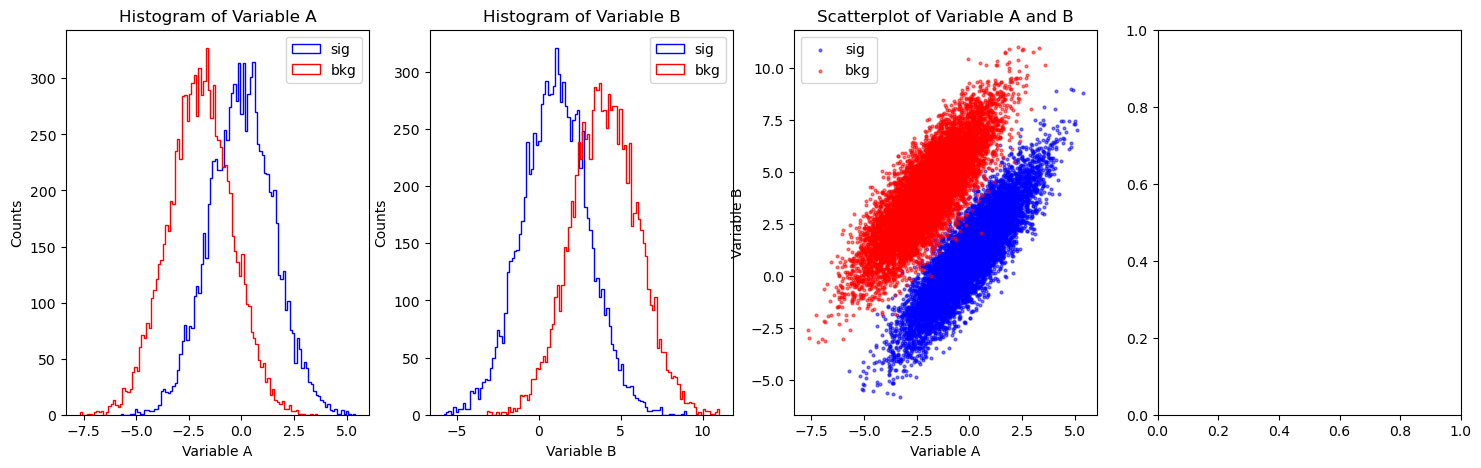

In [8]:
Nbins = 100

fig, ax = plt.subplots(1, 4, figsize=(18, 5))

ax[0].hist(sig[:, 0], Nbins, histtype='step', label='sig', color='blue')
ax[0].hist(bkg[:, 0], Nbins, histtype='step', label='bkg', color='red')
ax[0].set(xlabel='Variable A', ylabel='Counts', title='Histogram of Variable A')
ax[0].legend()

ax[1].hist(sig[:, 1], Nbins, histtype='step', label='sig', color='blue')
ax[1].hist(bkg[:, 1], Nbins, histtype='step', label='bkg', color='red')
ax[1].set(xlabel='Variable B', ylabel='Counts', title='Histogram of Variable B')
ax[1].legend()

ax[2].scatter(sig[:, 0], sig[:, 1], s=4, c='blue',  label='sig', alpha=0.5)
ax[2].scatter(bkg[:, 0], bkg[:, 1], s=4, c='red', label='bkg', alpha=0.5)
ax[2].set(xlabel='Variable A', ylabel='Variable B', title='Scatterplot of Variable A and B')
ax[2].legend();

## Fishers Discriminant: 
How to perform a __[Fishers Linear Discimant Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)__ in Scikit Learn.  



First load the proper package:

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

Then we convert the two numpy arrays one big one called `X`. `y` denotes the class (1 for signal, 0 for background)

In [10]:
X = np.vstack((sig, bkg))

y = np.zeros(2*N) 
y[:N] = 1

Now do the Linear Discriminant Analysis (LDA):

In [11]:
# initialise the LDA method
sklearn_lda = LDA()

# fit the data
sklearn_lda.fit(X, y)

# transform the data
X_lda_sklearn = sklearn_lda.transform(X) 

print(f"LDA coefficients: {sklearn_lda.scalings_}")

LDA coefficients: [[ 1.19971746]
 [-0.90993333]]


Extract the tranformed variables

In [12]:
sig_lda = X_lda_sklearn[y == 1]
bkg_lda = X_lda_sklearn[y == 0]

and plot it on the figure:

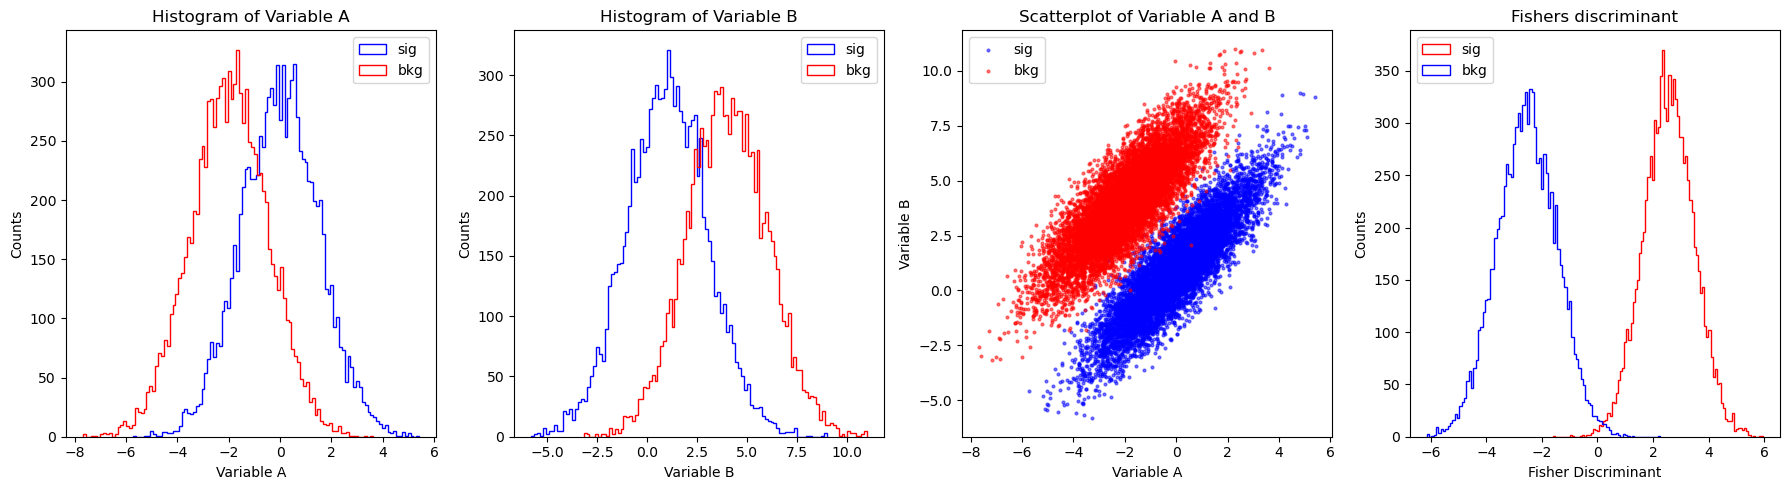

In [13]:
ax[3].hist(sig_lda, Nbins, histtype='step', label='sig', color='red')
ax[3].hist(bkg_lda, Nbins, histtype='step', label='bkg', color='blue')
ax[3].set(xlabel='Fisher Discriminant', ylabel='Counts', title='Fishers discriminant')
ax[3].legend()

fig.tight_layout()

fig

# What if the dataset was completely different?

Now we want to eksamine the dataset given in `DataSet_ML.txt`. First we load it, extract the relevant data and plot it:


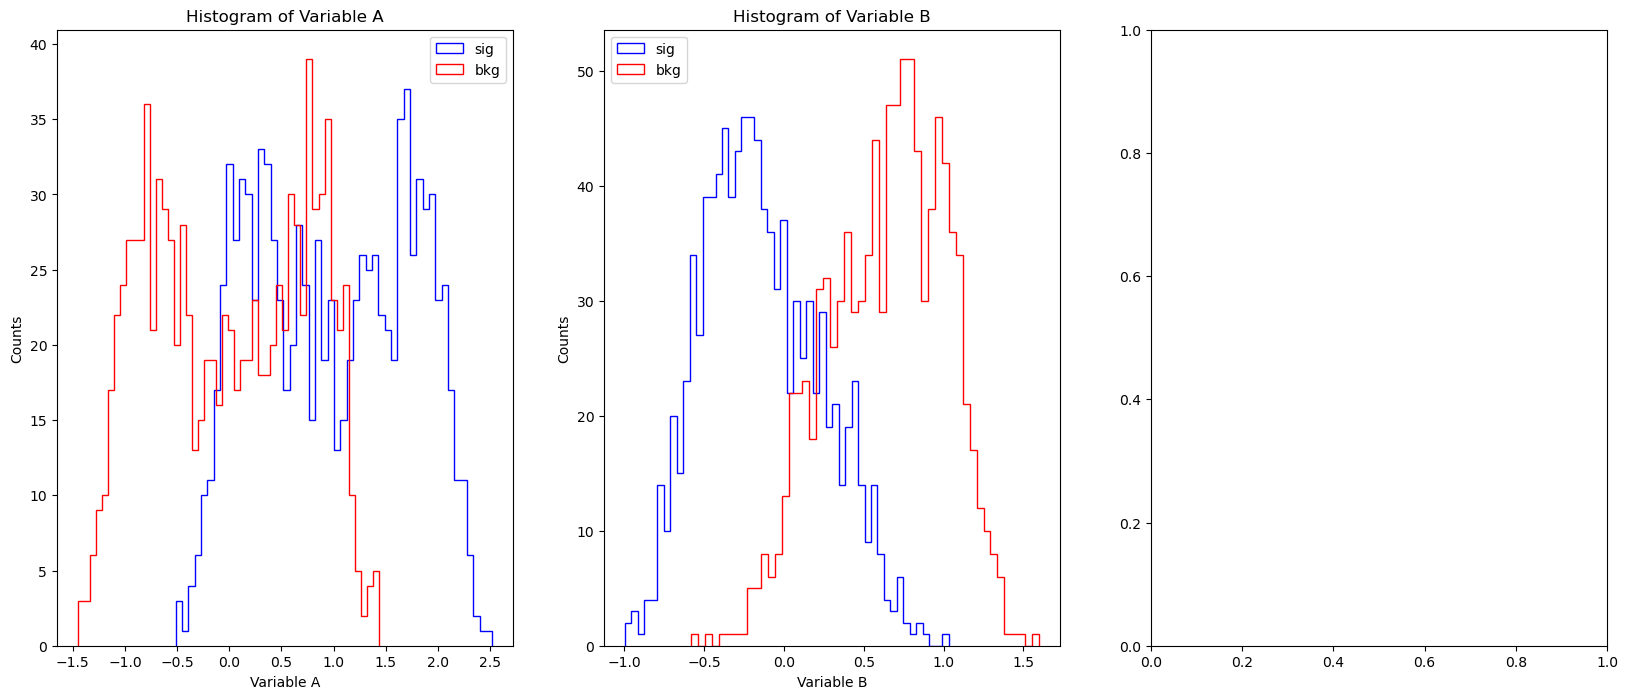

In [14]:
# Load the data:
data = np.loadtxt('DataSet_ML.txt')
N = len(data)
Nbins = 50

# Divide data into input variables (X) and "target" variable (y)
X = data[:, :2]
y = data[:, 2]

# As signal and background:
sig = X[y == 1]
bkg = X[y == 0]

fig2, ax2 = plt.subplots(1, 3, figsize=(20, 8))
ax2[0].hist(sig[:, 0], Nbins, histtype='step', label='sig', color='blue')
ax2[0].hist(bkg[:, 0], Nbins, histtype='step', label='bkg', color='red')
ax2[0].set(xlabel='Variable A', ylabel='Counts', title='Histogram of Variable A')
ax2[0].legend()

ax2[1].hist(sig[:, 1], Nbins, histtype='step', label='sig', color='blue')
ax2[1].hist(bkg[:, 1], Nbins, histtype='step', label='bkg', color='red')
ax2[1].set(xlabel='Variable B', ylabel='Counts', title='Histogram of Variable B')
ax2[1].legend();

# TASK:
 1. Think about how you think the above data looks in 2D before you continue.
 2. Draw on a piece of paper, what you think it looks like in 2D before you continue.
 
When you have talked with your collaborators you should uncomment the below five lines.

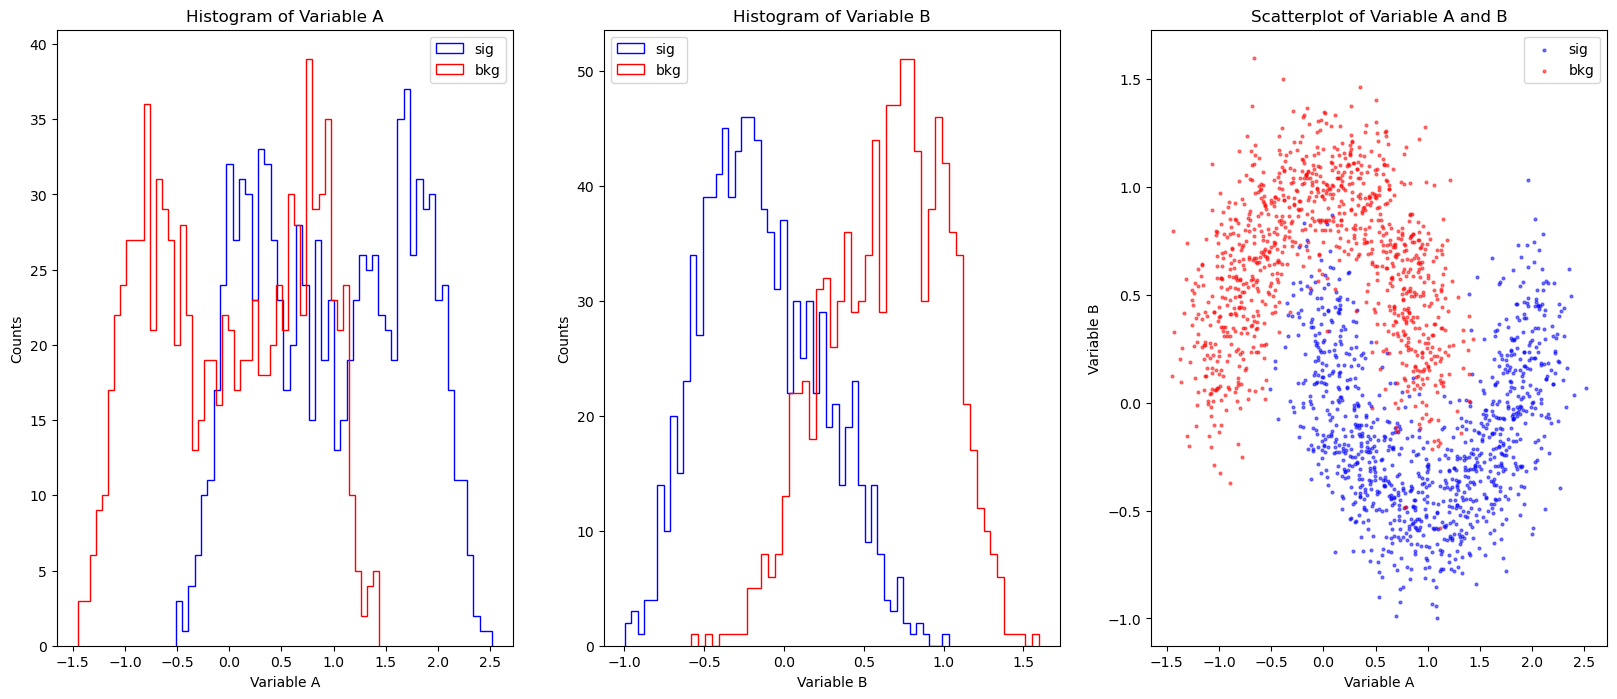

In [15]:
ax2[2].scatter(sig[:, 0], sig[:, 1], s=4, c='blue',  label='sig', alpha=0.5)
ax2[2].scatter(bkg[:, 0], bkg[:, 1], s=4, c='red', label='bkg', alpha=0.5)
ax2[2].set(xlabel='Variable A', ylabel='Variable B', title='Scatterplot of Variable A and B')
ax2[2].legend()
fig2

LDA coefficients [[ 0.74009504]
 [-2.30823105]]


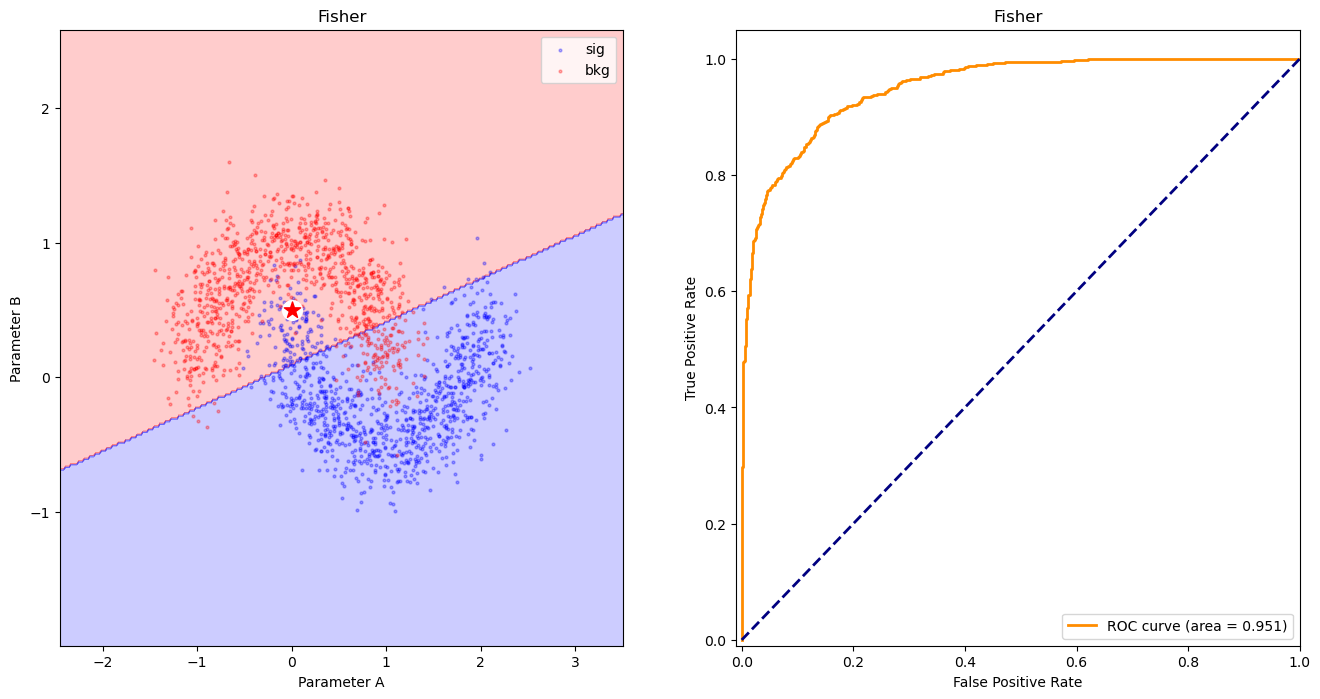

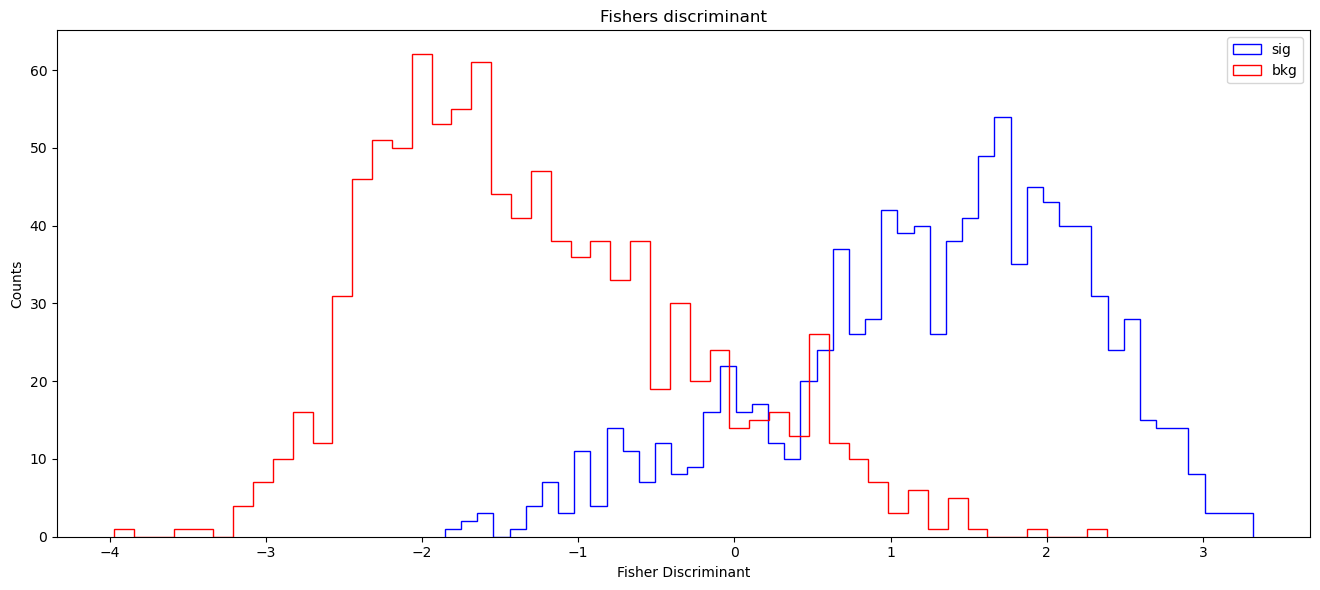

In [16]:
# LDA
clf_fisher = LDA()                      # Initialise the LDA method
clf_fisher.fit(X, y)                    # Fit the data
X_fisher = clf_fisher.transform(X)      # Transform the data
print("LDA coefficients", clf_fisher.scalings_)

# Extract the tranformed variables
sig_fisher = X_fisher[y == 1]
bkg_fisher = X_fisher[y == 0]

plot_fisher_discriminant = True

if plot_fisher_discriminant :        # You gotta switch this on, if you want to see it :-)

    # Plot decision region of fisher:
    fig_fisher, ax_fisher = plot_decision_regions(X, y, classifier=clf_fisher, title='Fisher')

    # Plot fisher discriminant values:
    fig_fisher2, ax_fisher2 = plt.subplots(figsize=(13.3, 6))
    ax_fisher2.hist(sig_fisher, Nbins, histtype='step', label='sig', color='blue')
    ax_fisher2.hist(bkg_fisher, Nbins, histtype='step', label='bkg', color='red')
    ax_fisher2.set(xlabel='Fisher Discriminant', ylabel='Counts', title='Fishers discriminant')
    ax_fisher2.legend()
    fig_fisher2.tight_layout()

## Decision Trees

We load __[Decision Trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)__ from Scikit-learn (sklearn). At first try to increase the `max_depth` slider and see how that affects the plots. Does that make sense? For a given `max_depth`, e.g. `max_depth = 30`, change the `min_samples_leaf` and see how it simplifies (via _regularization_) the model. Think about when you'd want a simpler model. Finally, given a set of values for `max_depth` and `min_samples_leaf` switch between `criterion` being `gini` and `entropy`. Does this change much? 

In [17]:
from sklearn.tree import DecisionTreeClassifier

def animate_ML_estimator_DT(criterion, min_samples_leaf=1, max_depth=1):
    animate_ML_estimator_generator(DecisionTreeClassifier, 'Decision Tree', X, y, 
                                   max_depth=max_depth, 
                                   criterion=criterion,
                                   #splitter=splitter,
                                   #min_samples_split=min_samples_split, 
                                   min_samples_leaf=min_samples_leaf)

kwargs_DT = { 'max_depth': (1, 50), 
              'criterion': ["gini", "entropy"], 
              #'splitter': ["best", "random"], 
              #'min_samples_split': (2, 50),
              'min_samples_leaf': (1, 50),
            }    


interactive_plot = interactive(animate_ML_estimator_DT, **kwargs_DT)
interactive_plot

interactive(children=(Dropdown(description='criterion', options=('gini', 'entropy'), value='gini'), IntSlider(…

## Boosted Decision Trees (BDTs)

For __[BDTs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier)__ try to slowly increase `n_estimators` and see how it affects the model. Does it make sense? Try also to increase the learning rate and see what that changes:


In [18]:
from sklearn.ensemble import AdaBoostClassifier

def animate_ML_estimator_BDT(learning_rate=1., n_estimators=1):
    animate_ML_estimator_generator(AdaBoostClassifier, 'Boosted Decision Trees', X, y, 
                                   learning_rate=learning_rate, 
                                   n_estimators=n_estimators,
                                   )

kwargs_BDT = {'learning_rate': (0.01, 2, 0.01), 
              'n_estimators': (1, 100),
            }    

interactive_plot = interactive(animate_ML_estimator_BDT, **kwargs_BDT)
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='learning_rate', max=2.0, min=0.01, step=0.01), IntSl…

## k-Nearest Neighbours

For __[kNNs](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)__ we only have the parameter n_neighbors to change:

In [19]:
from sklearn.neighbors import KNeighborsClassifier

def animate_ML_estimator_KNN(n_neighbors=1):
    animate_ML_estimator_generator(KNeighborsClassifier, 'KNN', X, y, n_neighbors=n_neighbors)

kwargs_KNN = {'n_neighbors': (1, 50), 
            }    

interactive_plot = interactive(animate_ML_estimator_KNN, **kwargs_KNN)
interactive_plot

interactive(children=(IntSlider(value=1, description='n_neighbors', max=50, min=1), Output()), _dom_classes=('…

## Support Vector Machine (SVM):

__[SVms](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)__ are quite different ML models than the rest and we won't be going through it in much detail. However, see if you can make sense of the difference between the `RBF` kernel compared to the `poly` one. Also, how much does `C` matter for the different kernels?
Notice that `degree` is only relevant for the `poly` kernel.  

In [20]:
from sklearn.svm import SVC

def animate_ML_estimator_SVM(kernel='rbf', C=1, degree=2, ):
    animate_ML_estimator_generator(SVC, 'SVM', X, y, 
                                   #gamma=gamma,
                                   gamma='scale',
                                   kernel=kernel, 
                                   C=C,
                                   
                                   probability=True,
                                   degree=degree,
                                   )

kwargs_SVM = {'C': (0.1, 10),
              'kernel': ['poly', 'rbf'],
              'degree': (1, 10),
              #'gamma': (0.1, 10),
            }    

interactive_plot = interactive(animate_ML_estimator_SVM, **kwargs_SVM)
interactive_plot


interactive(children=(Dropdown(description='kernel', index=1, options=('poly', 'rbf'), value='rbf'), FloatSlid…

***

 Machine Learning (ML) is a fascinating subject, which is very much in vouge these days.
 There are two classic usages for ML:
 
  - Classification (determine which category a case belongs to, i.e. ill or healthy)
  - Regression (determine a value, i.e. what was the energy of this electron)

 Python has packages - "scikit-learn" (among others) - that allows anybody to  easily apply ML to smaller scale problems (i.e. below 1 GB). The following questions/exercise is meant to illustrate a classification problem, and to wet your appetite for more...


# Questions:

1. Consider the data, and make sure that you by eye can see, how an algorithm should decide between the two categories. Also see, if you can guess how well the Fisher performs. What is the error rate of type1 and type2 roughly?

2. Now consider the various ML algorithms. Can you (again by eye) tell, if it is doing "just well" or "very well"? I.e. can you rank the methods by eye? What you have tried this, compare to the ROC curves and see how well you did.

3. What we are currently plotting in the ROCcurve is the ROC-curve for the training data. Try to split up the data into a training and a test set: Let 2/3 be for training, and then apply the result of this training on the last 1/3 of the data, which is thus "unseen" by the algorithm, corresponding to "new data". Then add the ROC-curve of the test set to the `plot_decision_regions` function.

4. Try to put all the ROC curves into one final plot, which shows how well the different methods perform.


### Advanced questions:

5. Try to find some other data, and apply the above ML methods to it. Can you get it to run there, and does it perform better than other methods you can implement yourself?

# Learning points:

The exercise is mostly meant for illustration, and for giving the opportunity to play around.

From this exercise you should:
1. Have an idea of how Machine Learning (ML) manages to work in many dimensions in a non-linear way.
2. Know about how Tree-based and Neural Network-based algorithms work.
3. That you don't code things up from scratch, but use packages for ML.